# Real time Twitter Sentiment Analysis with PySpark

## Install required packages and libraries

In [1]:
!pip install pyspark
#!pip install kaggle
#!pip install wordcloud

## Import the required packages and libraries

In [3]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk

## Load the Data from Kaggle

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Start the Spark session 

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Twitter').getOrCreate()
spark


## Loading the data in Spark Dataframe

In [6]:
#df = spark.read.csv('filename.csv', header = True, inferSchema = True)
df = spark.read.csv("training.1600000.processed.noemoticon.csv", inferSchema=True)

In [7]:
df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

#### Renaming the columns

In [8]:
df = df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
  .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

#### Checking the Schema

In [9]:
df.printSchema() 

root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



## Inspect and Preprocessing the Dataset

In [10]:
df.head(5)

[Row(target=0, id=1467810369, date='Mon Apr 06 22:19:45 PDT 2009', flag='NO_QUERY', user='_TheSpecialOne_', text="@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 Row(target=0, id=1467810672, date='Mon Apr 06 22:19:49 PDT 2009', flag='NO_QUERY', user='scotthamilton', text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(target=0, id=1467810917, date='Mon Apr 06 22:19:53 PDT 2009', flag='NO_QUERY', user='mattycus', text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(target=0, id=1467811184, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='ElleCTF', text='my whole body feels itchy and like its on fire '),
 Row(target=0, id=1467811193, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='Karoli', text="@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because

In [11]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  6 columns in the dataset.


#### Check for missing values!!

In [12]:
df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,target,id,date,flag,user,text
0,0,0,0,0,0,0


There are no missing values in the dataset.

#### Check for duplicates!!

In [13]:
df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


There are no duplicates in the dataset.

#### Check types of columns!!

In [14]:
df.dtypes

[('target', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('flag', 'string'),
 ('user', 'string'),
 ('text', 'string')]

s

In [15]:
#df.summary().show()
#df.describe().show()

We only need the target and the text column for sentiment analyses, that's why dropping the rest of the columns.

In [16]:
drop_cols= ("id","date","flag","user")
df = df.drop(*drop_cols)

In [17]:
df.printScshema()

root
 |-- target: integer (nullable = true)
 |-- text: string (nullable = true)



In [18]:
df.show(5, truncate = False)

+------+-----------------------------------------------------------------------------------------------+
|target|text                                                                                           |
+------+-----------------------------------------------------------------------------------------------+
|0     |     angry                                                                                     |
|0     |   @Beansummer                                                                                 |
|0     |   awwwww i really hate this.                                                                  |
|0     |   i am soooo sad...at this point of night i'd be cuddling with jonathan like i did for 4 years|
|0     |  Hand quilting it is then...                                                                  |
+------+-----------------------------------------------------------------------------------------------+
only showing top 5 rows



In [19]:
df.select("target").distinct().show()

+------+
|target|
+------+
|     4|
|     0|
+------+



There are only two distinct values in target column. O for "Negative" and 4 for "Positive" according to data description. Let's change the value of Positive from 4 to 1.

In [20]:
df.createOrReplaceTempView('temp')
df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')
df.show(5, truncate = False)

+-----+-----------------------------------------------------------------------------------------------+
|label|text                                                                                           |
+-----+-----------------------------------------------------------------------------------------------+
|0.0  |     angry                                                                                     |
|0.0  |   @Beansummer                                                                                 |
|0.0  |   awwwww i really hate this.                                                                  |
|0.0  |   i am soooo sad...at this point of night i'd be cuddling with jonathan like i did for 4 years|
|0.0  |  Hand quilting it is then...                                                                  |
+-----+-----------------------------------------------------------------------------------------------+
only showing top 5 rows



In [21]:
df.tail(5)

[Row(label=Decimal('1.0'), text='your such a good snger @ddlovato!  xoxo'),
 Row(label=Decimal('1.0'), text='yum yum pizza take out '),
 Row(label=Decimal('1.0'), text="yummy ! drake's on this episode of degrassi "),
 Row(label=Decimal('1.0'), text='zzzzzzzzz ... then Terra Brunch in Malibu ! Come on folks.... beautiful weather on a Sunday.... come for brunch in Malibu '),
 Row(label=Decimal('1.0'), text='저�?� #goodnight! ')]

In [22]:
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|800000|
|  1.0|800000|
+-----+------+



## Text Preprocessing

#### Remove stopwords, punctuations, links, and stem the data

In [23]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [24]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/comp6235/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [26]:
%%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 8.99 ms, sys: 1.41 ms, total: 10.4 ms
Wall time: 41.9 ms


In [27]:
df.show()

+-----+--------------------+--------------------+
|label|                text|        text_cleaned|
+-----+--------------------+--------------------+
|  0.0|               angry|               angry|
|  0.0|         @Beansummer|          beansummer|
|  0.0|   awwwww i reall...|  awwwww really hate|
|  0.0|   i am soooo sad...|soooo sad point n...|
|  0.0|  Hand quilting i...|       hand quilting|
|  0.0|  but chilli praw...|chilli prawns mak...|
|  0.0| #betseyjohnson w...|betseyjohnson nec...|
|  0.0| 1 week before th...|1 week palm pre c...|
|  0.0| @joseke Trent Re...|joseke trent rezn...|
|  0.0| Cant do this any...|        cant anymore|
|  0.0| I want to go to ...|want go smx advan...|
|  0.0| Now Chuck is not...|chuck talking dri...|
|  0.0| Plane late 1.5 h...|plane late 1 5 hr...|
|  0.0| We have bagworms...|bagworms depressi...|
|  0.0|      at last night |          last night|
|  0.0| boo you suck...b...|boo suck thanks o...|
|  0.0| didnt sticth tod...|didnt sticth toda...|


In [28]:
df = df.drop("text")

## Displaying Word Cloud

In [29]:
from wordcloud import WordCloud

In [30]:
#!pip install wordcloud

In [31]:
pandas_df = df.toPandas()
pandas_df.head()

,label,text_cleaned
0,0.0,angry
1,0.0,beansummer
2,0.0,awwwww really hate
3,0.0,soooo sad point night cuddling jonathan like 4...
4,0.0,hand quilting


#### Positive Sentiments Word Cloud

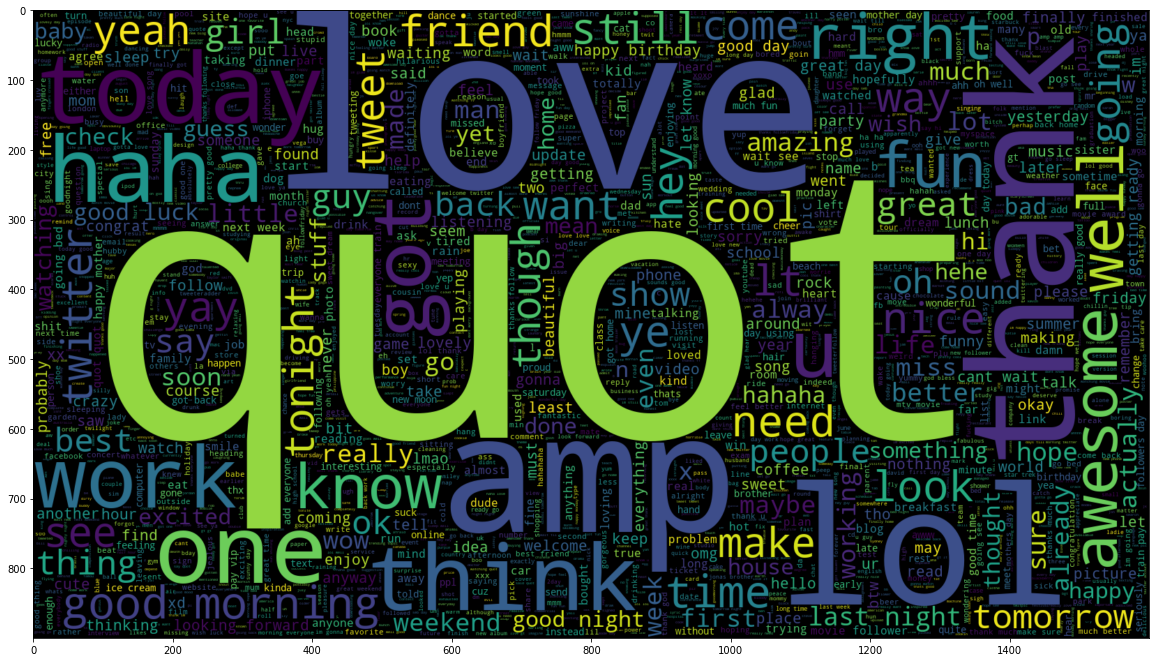

In [32]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Negative Sentiments Word Cloud

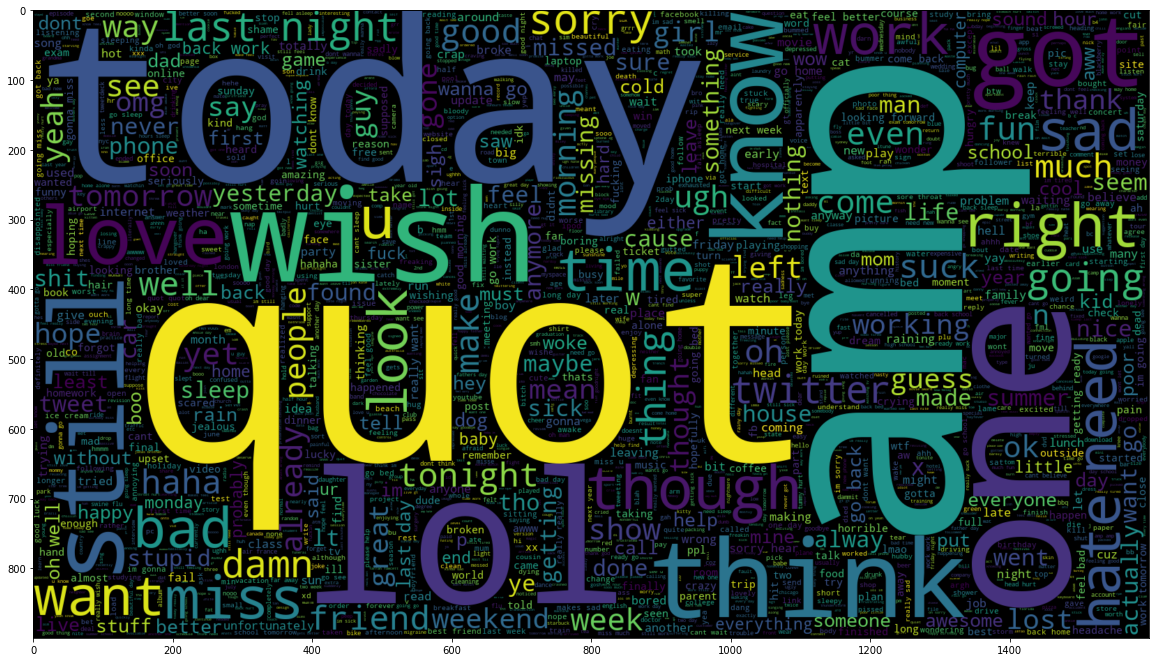

In [33]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==0.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Preparing Data for Model Building

#### Tokenizing the Text

In [34]:
from pyspark.ml.feature import Tokenizer

In [35]:
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(df)
words_tokens.show()

+-----+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|
+-----+--------------------+--------------------+
|  0.0|               angry|             [angry]|
|  0.0|          beansummer|        [beansummer]|
|  0.0|  awwwww really hate|[awwwww, really, ...|
|  0.0|soooo sad point n...|[soooo, sad, poin...|
|  0.0|       hand quilting|    [hand, quilting]|
|  0.0|chilli prawns mak...|[chilli, prawns, ...|
|  0.0|betseyjohnson nec...|[betseyjohnson, n...|
|  0.0|1 week palm pre c...|[1, week, palm, p...|
|  0.0|joseke trent rezn...|[joseke, trent, r...|
|  0.0|        cant anymore|     [cant, anymore]|
|  0.0|want go smx advan...|[want, go, smx, a...|
|  0.0|chuck talking dri...|[chuck, talking, ...|
|  0.0|plane late 1 5 hr...|[plane, late, 1, ...|
|  0.0|bagworms depressi...|[bagworms, depres...|
|  0.0|          last night|       [last, night]|
|  0.0|boo suck thanks o...|[boo, suck, thank...|
|  0.0|didnt sticth toda...|[didnt, sticth, t...|


#### Applying CountVectorizer

In [36]:
from pyspark.ml.feature import CountVectorizer

In [37]:
count = CountVectorizer (inputCol="words_tokens", outputCol="rawFeatures")
model = count.fit(words_tokens)
featurizedData = model.transform(words_tokens)
featurizedData.show()


+-----+--------------------+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|         rawFeatures|
+-----+--------------------+--------------------+--------------------+
|  0.0|               angry|             [angry]|(262144,[1581],[1...|
|  0.0|          beansummer|        [beansummer]|(262144,[217240],...|
|  0.0|  awwwww really hate|[awwwww, really, ...|(262144,[18,69,25...|
|  0.0|soooo sad point n...|[soooo, sad, poin...|(262144,[3,21,43,...|
|  0.0|       hand quilting|    [hand, quilting]|(262144,[666,2448...|
|  0.0|chilli prawns mak...|[chilli, prawns, ...|(262144,[54,60,41...|
|  0.0|betseyjohnson nec...|[betseyjohnson, n...|(262144,[26,661,9...|
|  0.0|1 week palm pre c...|[1, week, palm, p...|(262144,[66,101,1...|
|  0.0|joseke trent rezn...|[joseke, trent, r...|(262144,[39,609,6...|
|  0.0|        cant anymore|     [cant, anymore]|(262144,[83,294],...|
|  0.0|want go smx advan...|[want, go, smx, a...|(262144,[4,26,44,...|
|  0.0

#### Applying Term Frequency - Inverse Document Frequency (TF-IDF)

In [38]:
from pyspark.ml.feature import IDF

In [39]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()  

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[1581],[7...|
|  0.0|(262144,[217240],...|
|  0.0|(262144,[18,69,25...|
|  0.0|(262144,[3,21,43,...|
|  0.0|(262144,[666,2448...|
|  0.0|(262144,[54,60,41...|
|  0.0|(262144,[26,661,9...|
|  0.0|(262144,[66,101,1...|
|  0.0|(262144,[39,609,6...|
|  0.0|(262144,[83,294],...|
|  0.0|(262144,[4,26,44,...|
|  0.0|(262144,[9,21,52,...|
|  0.0|(262144,[19,40,10...|
|  0.0|(262144,[4,29,91,...|
|  0.0|(262144,[21,34],[...|
|  0.0|(262144,[6,15,29,...|
|  0.0|(262144,[6,11,296...|
|  0.0|(262144,[2,9,1589...|
|  0.0|(262144,[31,147,2...|
|  0.0|(262144,[7,23,31,...|
+-----+--------------------+
only showing top 20 rows



In [40]:
df_final = rescaledData.select("label", "features")# We want only the label and features columns for our machine learning models

#### Splitting the data into training and test dataset

In [41]:
seed = 42  # set seed for reproducibility

trainDF, testDF = df_final.randomSplit([0.7,0.3],seed)

In [42]:
trainDF.count()

1120124

In [43]:
trainDF.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|      (262144,[],[])|
|  0.0|(262144,[0,1,2,6,...|
|  0.0|(262144,[0,1,7,32...|
|  0.0|(262144,[0,1,9,38...|
|  0.0|(262144,[0,1,10,2...|
|  0.0|(262144,[0,1,17],...|
|  0.0|(262144,[0,1,48,5...|
|  0.0|(262144,[0,2,5,23...|
|  0.0|(262144,[0,2,8,14...|
|  0.0|(262144,[0,2,28,4...|
|  0.0|(262144,[0,2,149,...|
|  0.0|(262144,[0,3,9,13...|
|  0.0|(262144,[0,3,10,2...|
|  0.0|(262144,[0,3,18,2...|
|  0.0|(262144,[0,3,47,5...|
|  0.0|(262144,[0,3,48,1...|
|  0.0|(262144,[0,3,55,9...|
|  0.0|(262144,[0,4,12,2...|
|  0.0|(262144,[0,4,20,2...|
|  0.0|(262144,[0,5,52,1...|
+-----+--------------------+
only showing top 20 rows



In [44]:
trainDF.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|560061|
|  1.0|560063|
+-----+------+



In [45]:
testDF.count()

479876

## Training the Model

In [46]:
from pyspark.ml.classification import LogisticRegression

In [47]:
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
model = lr.fit(trainDF)

In [48]:
predictions = model.transform(testDF)

In [49]:
pred = predictions.toPandas()
pred.head()

,label,features,rawPrediction,probability,prediction
0,0.0,"(2.905880768659501, 2.9672790755090057, 0.0, 0...","[4.126993673796542, -4.126993673796542]","[0.9841247859179291, 0.01587521408207108]",0.0
1,0.0,"(2.905880768659501, 2.9672790755090057, 0.0, 0...","[0.08142133727439366, -0.08142133727439366]","[0.5203440964062445, 0.4796559035937556]",0.0
2,0.0,"(2.905880768659501, 2.9672790755090057, 0.0, 0...","[2.3933026767986836, -2.3933026767986836]","[0.9163151713639776, 0.08368482863602253]",0.0
3,0.0,"(2.905880768659501, 2.9672790755090057, 0.0, 0...","[0.7305384743941097, -0.7305384743941097]","[0.6749234259571928, 0.3250765740428071]",0.0
4,0.0,"(2.905880768659501, 0.0, 3.0071857325997775, 0...","[-1.7258209324778986, 1.7258209324778986]","[0.15112290920554722, 0.8488770907944527]",1.0


## Evaluating the Model

In [50]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [51]:
evaluator = BinaryClassificationEvaluator(labelCol = "label", metricName='areaUnderROC')

In [52]:
areaUnderROC = evaluator.evaluate(predictions)
print(f"The testing areaUnderROC of our Logistic Regression model is: {areaUnderROC}")

The testing areaUnderROC of our Logistic Regression model is: 0.8196416434622678


#### Classification Report and Confusion Matrix

In [53]:
y_true = pred['label'].astype('float')
y_pred = pred['prediction']

In [54]:
y_true.value_counts()

0.0    239939
1.0    239937
Name: label, dtype: int64

In [55]:
y_pred.value_counts()

1.0    246834
0.0    233042
Name: prediction, dtype: int64

In [60]:
#!pip install sklearn
#!pip install seaborn

     |████████████████████████████████| 292 kB 14.3 MB/s eta 0:00:01


In [57]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76    239939
         1.0       0.75      0.77      0.76    239937

    accuracy                           0.76    479876
   macro avg       0.76      0.76      0.76    479876
weighted avg       0.76      0.76      0.76    479876



<AxesSubplot:>

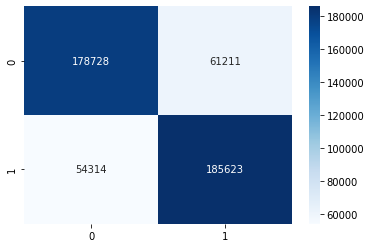

In [61]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')